In [1]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib.pyplot as plt

### data file

In [102]:
df = pd.read_csv('../../data/AloQuote_wide.csv')

In [4]:
df.shape

(401, 169)

In [104]:
df_index = pd.read_csv('../../data/index.csv')

In [17]:
df_index.shape

(401, 4)

In [18]:
def fix_ags5(x):
    if len(str(x))==4:
        return '0'+str(x)
    else:
        return str(x)

In [105]:
df = pd.merge(df_index, df, left_index=True, right_index=True)

In [106]:
df['ags5_fix'] = df['ags5'].apply(fix_ags5)

### geo file

In [23]:
gdf = gpd.read_file('../../georef-germany-kreis/georef-germany-kreis-millesime.shp')

In [24]:
gdf.shape

(401, 9)

<AxesSubplot:>

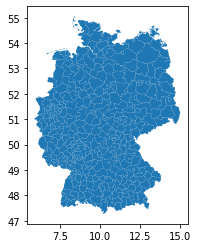

In [25]:
gdf.plot()

### merge files

In [110]:
merged = pd.merge(df, gdf, left_on='ags5_fix', right_on='krs_code')

In [111]:
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
merged['longitude'] = merged['coords'].str[0]
merged['latitude'] = merged['coords'].str[1]

In [112]:
merged = gpd.GeoDataFrame(merged)

In [115]:
date_cols = merged.columns[4:-13]

In [116]:
merged['last_time'] = merged[date_cols[-1]]-df[date_cols[-2]]
merged['last_year'] = merged[date_cols[-1]]-df[date_cols[-13]]
merged['last_time%'] = (merged[date_cols[-1]]-df[date_cols[-2]])/merged[date_cols[-1]]*100
merged['last_year%'] = (merged[date_cols[-1]]-df[date_cols[-13]])/merged[date_cols[-1]]*100

In [117]:
def plot_map_wide(df, col=None, annotate=False):
    if col==None:
        col = date_cols[-1]

    fig, ax = plt.subplots(figsize=(50,30))
    merged.plot(column=col, scheme="quantiles",
                #figsize=(50,30), 
                ax=ax,
                cmap='coolwarm', legend=True)
    ax.set_title(f'{col} in Germany by County',fontsize=15)

    if annotate==True:
        # filter
        q1 = merged[col].describe()['25%']
        q3 = merged[col].describe()['75%']
        # merged_filtered = merged[(merged[col]>=q1) & (merged[col]<=q3)]
        merged_filtered = merged[(merged[col]>=q3)]

        # add text
        for i in merged_filtered.index:
            ax.text(merged_filtered.longitude[i], merged_filtered.latitude[i],
                     f'{merged_filtered["kreis"][i]}\n{merged_filtered[col][i]}', fontsize=10)

    #return fig

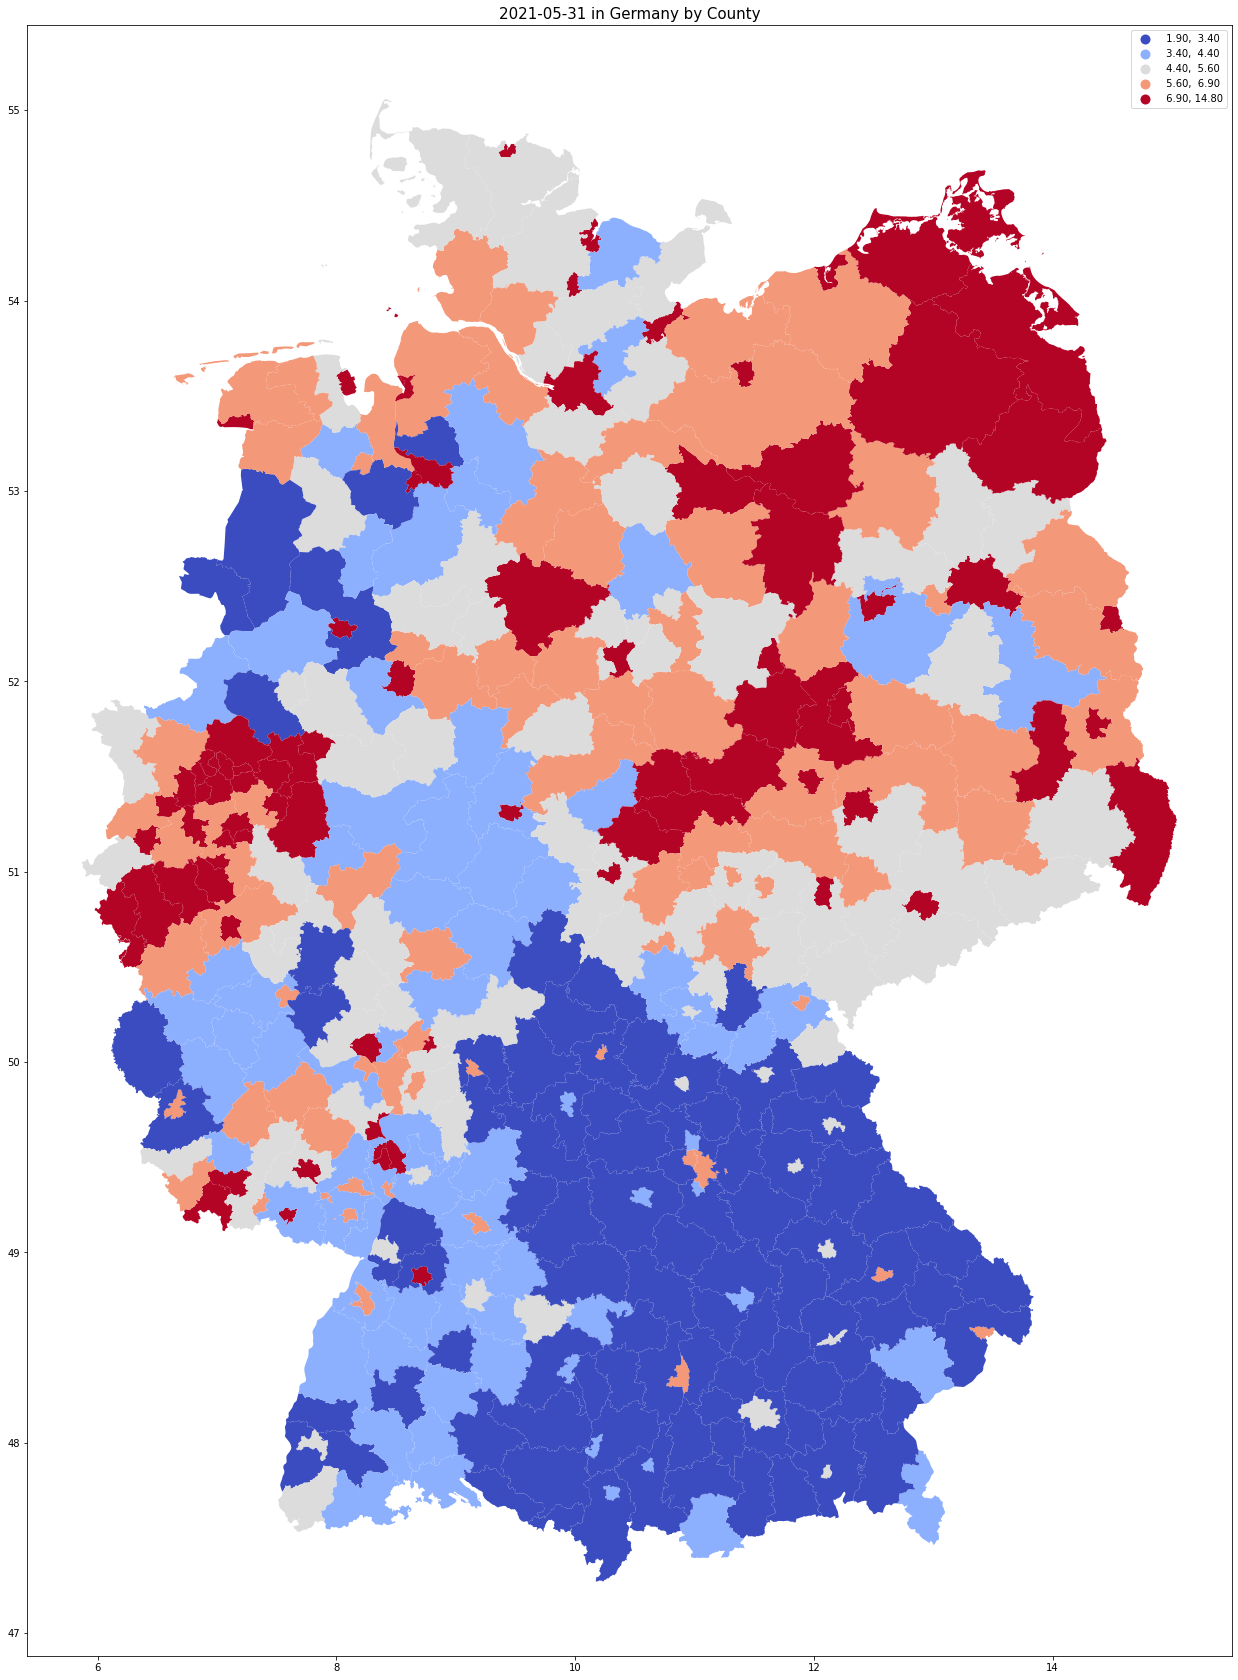

In [68]:
plot_map_wide(df)

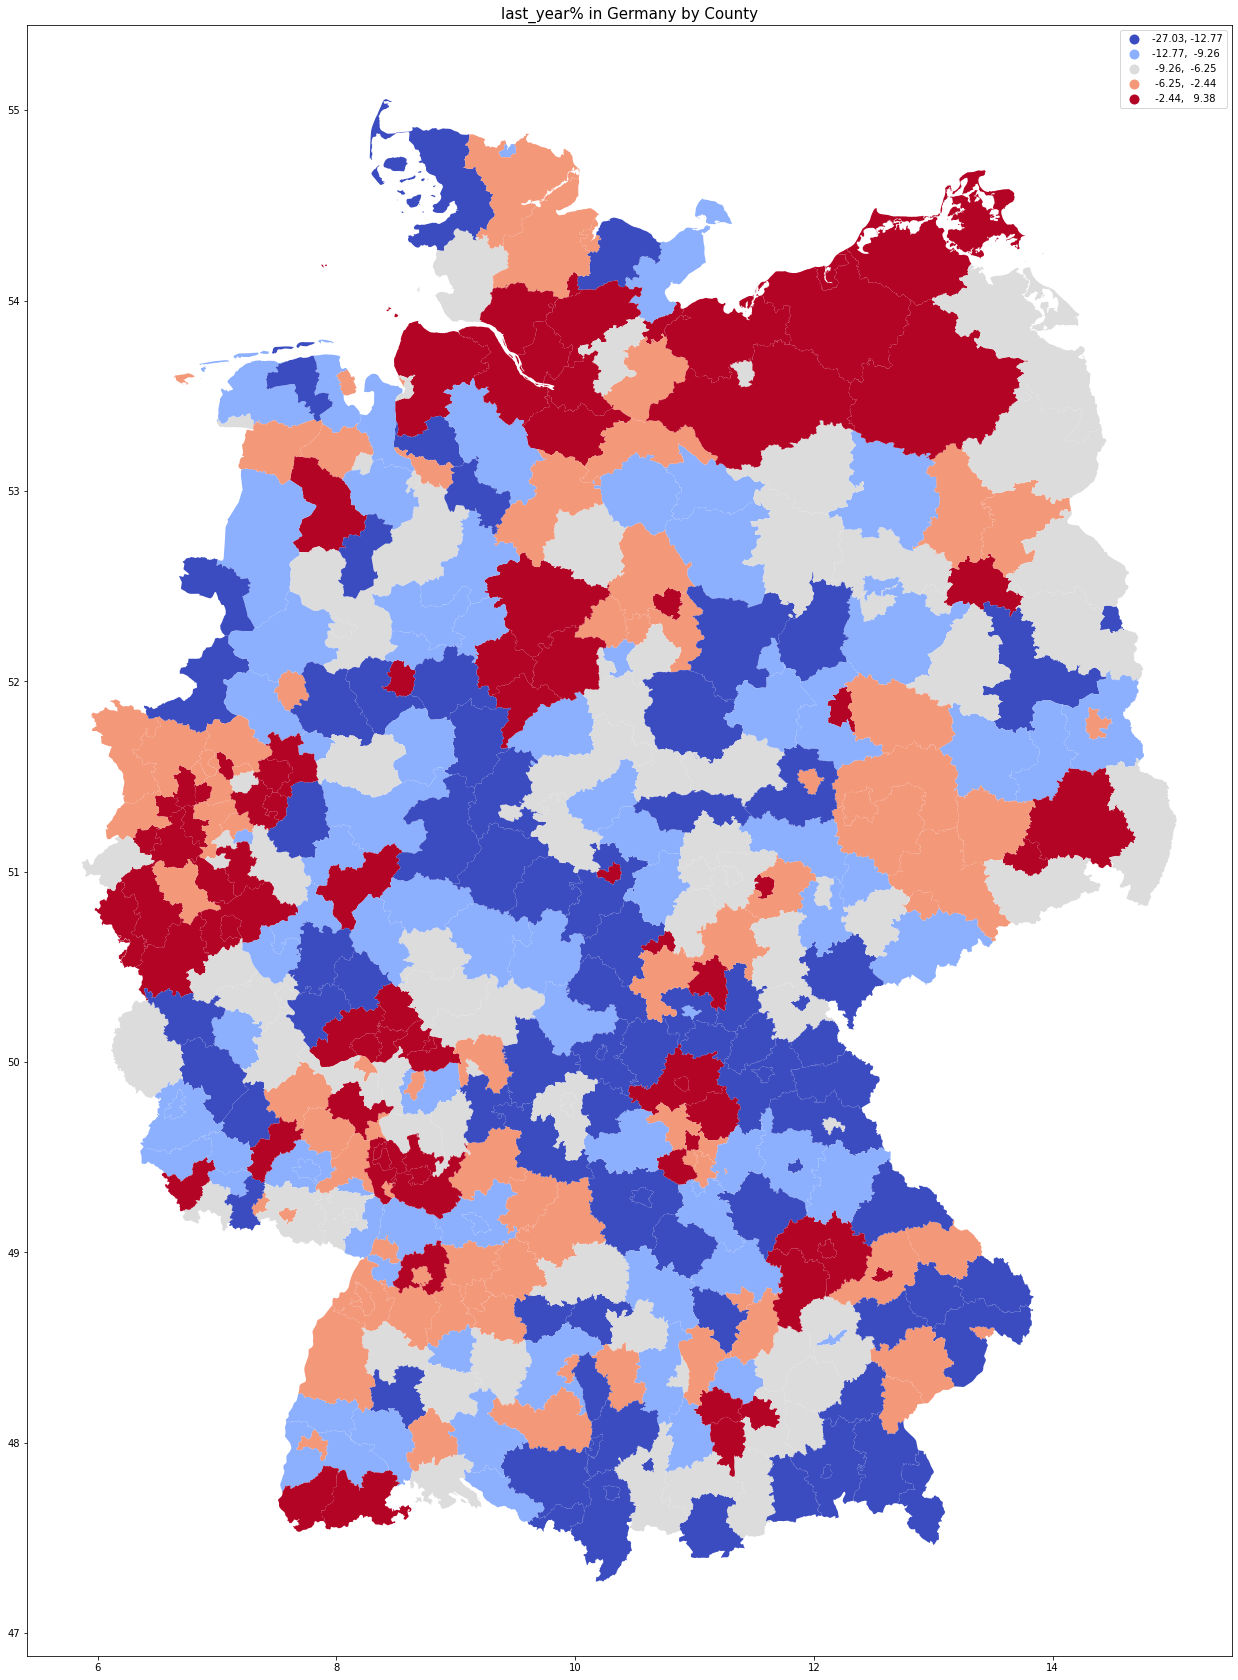

In [81]:
plot_map_wide(df, 'last_year%')